# The Harmonic Balance Method 

### Import Packages 

In [12]:
using LinearAlgebra
using DifferentialEquations
using FFTW

using BenchmarkTools

using Plots 

## Section 1: Introduction

We introduce the harmonic balance method for linear and non-linear ODEs and PDEs. 

The **goals** of this notebook include 

1. introduce the [harmonic balance method](https://en.wikipedia.org/wiki/Harmonic_balance) (a more intuitive introduction with examples would be nice to have) to approximate solutions of non-linear ordinary differential equations. This method will be introduced as an extension of the method of variation of constants for finding a particular solution for the non-homogeneous differential equation;

2. introduce the [NonlinearSolve.jl](https://docs.sciml.ai/NonlinearSolve/stable/) package to solve systems of non-linear algebraic equations resulting from the harmonic balance method. Analytical, numerical and symbolic methods to compute the Jacobian (derivative information) to be used within the Newton iteration (as search direction) will be explored.  

3. introduce the [DifferentialEquations.jl](https://docs.sciml.ai/DiffEqDocs/stable/) package to define initial value problems for second order differential equations and solve these problems numerically. We will use explicit and implicit time integration methods with an adaptively computed time-step for first order ODEs, second order ODEs and systems of first order ODEs. Examples of mass-spring and mass-spring-damper systems will be introduced. We wish to analyze the effect of damping, periodic forcing and the non-linearity of the equation. We will explore for to retrieve information from the solution data structure that DifferentialEquations.jl builds. 

4. introduce the the [Fast Fourier Transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform) and the package [FFTW.jl](https://juliamath.github.io/FFTW.jl/stable/) to compute the Fourier transform of the solution obtained by time-integration (or to decompose a function varrying in time into cosine and sine basis functions). This serves two purposes. The first purpose is to compute the spectral content (dominant frequencies and corresponding amplitudes) of the solution obtained after time-integration. The second purpose is to obtain criteria to compare the time-integation and harmonic balance solutions. 

## Section 2: Harmonic Balance Method for Linear ODEs

For linear ODEs, the harmonic balance method coincides with the method of variation of coefficients for finding a particular solution to the non-homogeneous equation of a linear  ordinary differential equation with constant coefficients. The method of variation of coeffients assumes a particular solution of the form $u_p(t) = A \, \cos(\omega_d \, t) + B \, \sin(\omega_d \, t)$ where $\omega_d$ denotes the driven frequency of the system. The method balances the terms in $\cos(\omega_d \, t)$ and $\sin(\omega_d \, t)$ in the LHS and RHS of the equation, solves a linear system for the coefficiens $A$ and $B$ thus finding $u_p(t)$.

## Section 3: Harmonic Balance Method for Non-Linear ODEs

In case of non-linear ODEs, the harmonic balance method extends the method of variation of coefficients. The harmonic balancee method assumes a particular solution of the form $u^{hb}(t) = A \, \cos(\omega_d \, t) + B \, \sin(\omega_d \, t)$, where $\omega_d$ denotes the driven frequency of the system. In its most simple form merely the driving frequency is taken into account. In more complex forms, multiples of the driving frequency is included. Then the particular solution $u^{hb}(t)$ is expressed as e.g. $u^{bh}(t) = A_1 \, \cos(\omega_d \, t) + B_1 \, \sin(\omega_d \, t) + A_2 \, \cos(2 \, \omega_d \, t) + B_2 \, \sin(2 \, \omega_d \, t)$. In the former case, the method balances the terms in $\cos(\omega_d \, t)$ and $\sin(\omega_d \, t)$ in the LHS and RHS of the equation, solves this time a non-linear system for the coefficiens $A$ and $B$ (the kind of non-linearity depends on the non-linearity in the ODE) thus finding $u^{hb}(t)$.

## Section 1.3: Example  

Here we study the harmonic balance method applied to the second order non-linear ordinary differential equation (ODE)  

$$
\ddot{u}(t) + u^3(t) = 0 \, .  
$$ 

This example was taken from the [wikipedia page on the harmonic_balance method](https://en.wikipedia.org/wiki/Harmonic_balance). Observe the cubic non-linearity in $u(t) $in the left-hand side. Observe no initial or boundary conditions are given. Observe that equation is non-linear and that therefore superposition does not apply. No external forcing is given. No damping (or term proportional to $\dot{u}(t)$) is given. We compare the harmonic balance solution with solutions obtained by time integration. To this end, we supply the ODE with initial conditions for position $u(t=0)$ and velocity $v(t=0) = \dot{u}(t=0)$. To compare results from the harmonic balance method and time integration, we transform the time-domain solution to frequency domain using the Fast Fourier Transform.  

## Section 2.3: Single Frequency Harmonic Balance Method

To find a solution of the above non-linear ODE by the harmonic balance method, we first assume solution of the form $u(t) = A \, \cos(\omega_0 \, t)$ (why?) where $A$ and $\omega_0$ are constants to be determined (we deliberately attach the index $0$ to the symbol $\omega_0$). The solution proposed here consists of a single harmonic (or mode). The amplitude $A$ is equal to the initial condition imposed on $u(t)$, i.e., $A = u(t=0)$. The extension to multiple harmonics will be discussed later. The symbol $\omega_0$ denotes the eigenfrequency of the system. The symbol $\omega_0$ is not to be confused with the symbol $\omega_d$ for the frequency of the external drive applied to the system that we will introduce later).

<b>Computing the Amplitude A</b> If $u(t) = A \, \cos(\omega_0 \, t)$, then $\ddot{u}(t) = - A \, \omega_0^2 \, \cos(\omega_0 \, t)$ and $u^3(t) = A^3 \, \cos^3(\omega_0 \, t)$. The latter term can be expanded into a first and third order harmonic as $u^3(t) = 3/4 \, A^3 \, \cos(\omega_0 \, t) + 1/4 \, A^3 \cos(3 \, \omega_0 \, t)$. Observe that the cubic non-linearity gives raise to the third-order harmonic (or mode) (i.e., the term $1/4 \, A^3 \cos(3 \, \omega_0 \, t)$). We will see this again in later examples. The equation $\ddot{u}(t) + u^3(t) = 0$ then becomes $ [ - A \, \omega_0^2 + 3/4 A^3] \cos(\omega_0 t)+ 1/4 A^3 \cos(3\omega_0 \, t) = 0$. Or after neglecting the third-order harmonic term (is this term small? more on neglecting this term later), $[ - A \, \omega_0^2 + 3/4 A^3] \cos(\omega_0 t) = 0 $, or $- A \, \omega_0^2 + 3/4 A^3 = 0$. We thus obtain that either $A = 0$ (the zero solution is indeed a solution of the non-linear ODE considered here) or $(-\omega_0^2 + 3/4 A^2) = 0$. The latter implies that $A = \sqrt{3}/2 \, \omega_0$.

<b>Solution Obtained and Discussion</b> The harmonic balance solution we thus obtain is 
$$
u^{hb}(t) = A \, \cos(\omega_0 \, t) =  u(t=0) \, \cos(\omega_0 \, t) = \sqrt{3}/2 \, \omega_0 \cos(\omega_0 \, t) \, . 
$$ 

Observe that 
1. the amplitude $A = \sqrt{3}/2 \, \omega_0$ is proportional to the eigenfrequency $\omega_0$. This amplitude is the initial condition for the position. Larger initial position results in larger frequency. 
3. the harmonic balance solution has a zero initial velocity (or first derivative). We will exploit this fact in constructing solutions using time integration in the next section;  
4. the solution $u(t) = \sqrt{3}/2 \, \omega_0 \cos(\omega_0 \, t)$ was obtained by neglecting the term $1/4 \, A^3 \cos(3 \, \omega_0 \, t) = 9 \sqrt{3}/(32) \, \omega_0 \cos(\omega_0 \, t)$. This term is not necessarily small, especially in case that $\omega_0$ is large; 

<b>Quality of the harmonic balance solution</b> The harmonic balance solution is expected to be good solution in case the exact solution varries at a single frequency. The harmonic balance method makes <b>two</b> approximations. First, assuming solution the solution to be of a particular form. Second, assuming the higher order harmonics to be small. 

To gain more insight, results of harmonic balancing and time-integration will be compared. 

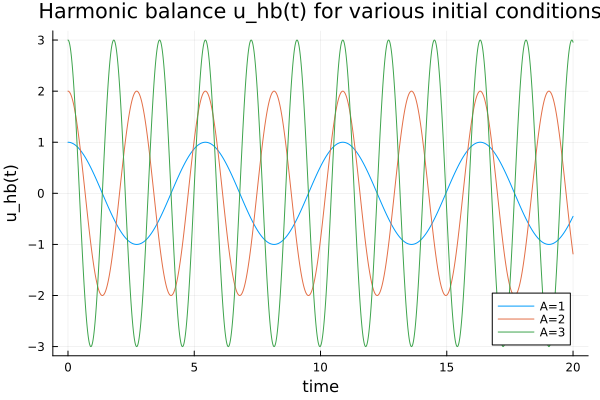

In [9]:
# harmonic balance solution with one harmonic 
function u_hb(t,u0) 
    A = u0
    om0 = 2/sqrt(3)*A
    return A*cos(om0*t)
end 

t = 0:0.01:20
u0 = 1; p1 = plot(t,u_hb.(t,Ref(u0)),label="A=1")
u0 = 2; p2 = plot!(t,u_hb.(t,Ref(u0)),label="A=2")
u0 = 3; p3 = plot!(t,u_hb.(t,Ref(u0)),label="A=3",xlabel="time",ylabel="u_hb(t)",title="Harmonic balance u_hb(t) for various initial conditions")

### Section 3.3: Comparison with Time-Integration 

Here we perform time integration on the ODE supplied with initial conditions for position $u_0 \in \{1,2,3\}$ (not sure about physical dimensions) and velocity $v_0 = 0$.  

We observe that as the initial value increases: 
1. the frequency of the oscillations increases (as shown by the harmonic balance solution); 
2. the temporal frequency content of the signal increases;
3. the amplitude of the difference between the harmonic balance and tim-integration method solution increaes; 

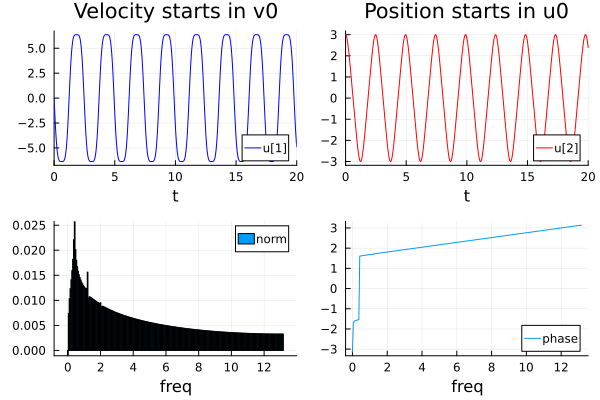

In [10]:
#..set initial conditions for position (u0) and velocity (v0)
u0    = 3.;
v0    = 0.0                        

#..set end time and time interval 
Tend = 20. # 1000.0 
tspan = (0.0,Tend)               

#..set rhs function of the ODE system 
function rhs!(ddu,u,p,t)
    ddu = -u^3
end

#..set problem 
prob = SecondOrderODEProblem(rhs!,v0,u0,tspan)

#..solve problem 
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8) 

# retrieve velocity and position at specific sampling points 
Nsamples = 500
Tstart = 1 
dt = (Tend-Tstart)/Nsamples
tsampled = Vector(Tstart:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]

# perform FFT of sampled position data 
uf = fft(usampled);

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

#..plot computed velocity and position in time  
p1 = plot(sol,idxs=1,line = :blue,title="Velocity starts in v0")
p2 = plot(sol,idxs=2,line = :red,title="Position starts in u0")
plot(p1,p2,layout = (1,2))

#..plot absolute value of FFT samples  
p3 = bar(fvec, 2.0/Nsamples * log.(abs.(uf[1:length(fvec)])),xlabel="freq",label="norm")
p4 = plot(fvec, angle.(uf[1:length(fvec)]),xlabel="freq",label="phase")
plot(p1,p2,p3, p4,layout = (2,2))

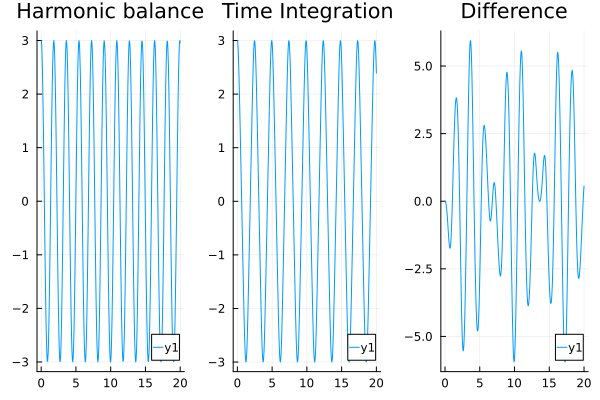

In [11]:
p1 = plot(sol.t,u_hb.(sol.t,u0),title="Harmonic balance")
p2 = plot(sol.t,sol.(sol.t,idxs=2),title="Time Integration")
p3 = plot(sol.t,u_hb.(sol.t,u0)-sol.(sol.t,idxs=2),title="Difference")
plot(p1,p2,p3,layout = (1,3))

### Section 4.3: Explore Further  

Extend the above discussion to   
1. third (and fitth) harmonic to verify to what extend gap with time-integration can be closed. Does a more generic implementation helps in this regard? 
2. $\ddot{u}(t) + u^n(t) = 0$ where $n=4,5,6,\ldots$ (thus considering other types of non-linearities). 
3. $\ddot{u}(t) + u^3(t) = B \, \cos(\omega_e t)$ where $\omega \neq \omega_0$ (thus adding periodic forcing to the model);
4. $\dot{u}(t) + u^3(t) = B \, \cos(\omega_e t)$ where $\omega \neq \omega_0$ (observe the first order derivative in the first term); 
5. solutions of the form $u(t) = A_1 \, \cos(\omega_0 \, t) + A_3 \, \cos(3 \omega_0 \, t)$ (thus taking the third order harmonic into account). Plot $A_1(\omega)$ and $A_3(\omega)$;
6. $\dot{u} = v$ and $\dot{v}(t) + u^3(t) = B \, \cos(\omega_e t)$ (this reformulating into a system of two coupled ordinary differential equations);

## Section 5: Harmonic Balance Method for Non-Linear Mass-Spring-Damper System 

See seperate notebook [mass-spring-damper-systems](./mass-spring-damper-systems.ipynb). 

## Section 6: Harmonic Balance Method for Polynomial Non-Linear ODEs in Julia 

The package [HarmonicBalance.jl](https://github.com/QuantumEngineeredSystems/HarmonicBalance.jl) implements the harmonic balance method for non-linear ODEs in Julia. The package implements the following steps
1. <b>harmonic_ansatz</b>: sets the harmonic ansatz; 
1. <b>get_harmonic_equations</b>: gets the harmonic equations; 
1. <b>drop_powers</b>: drops powers not defined in harmonic_ansatz from the harmonic equations;

The package [HarmonicBalance.jl](https://github.com/QuantumEngineeredSystems/HarmonicBalance.jl) uses in turn the package [juliahomotopycontinuation](https://www.juliahomotopycontinuation.org/) to solve the resulting linear system of non-linear polynomial equations. 

## Section 7: Harmonic  Balance Method for PDEs 

See seperate notebook.